## Description

This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

Content
It contains the following 6 fields:

1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2. ids: The id of the tweet ( 2087)
3. date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
4. flag: The query (lyx). If there is no query, then this value is NO_QUERY.
5. user: the user that tweeted (robotickilldozr)
6. text: the text of the tweet (Lyx is cool)

Reference: https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis

### 1. Loading Data

In [4]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matis\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [6]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### 2. Data Preprocessing

**Dataset details**

 - target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
 - ids: The id of the tweet ( 2087)
 - date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
 - flag: The query (lyx). If there is no query, then this value is NO_QUERY.
 - user: the user that tweeted (robotickilldozr)
 - text: the text of the tweet (Lyx is cool)

In [12]:
dataset_filename = os.listdir("input")[0]
print(dataset_filename)
dataset_path = os.path.join(".","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

training.1600000.processed.noemoticon.csv
Open file: .\input\training.1600000.processed.noemoticon.csv


In [13]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [14]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### 3. Feature Engineering

In [15]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [16]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 556 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

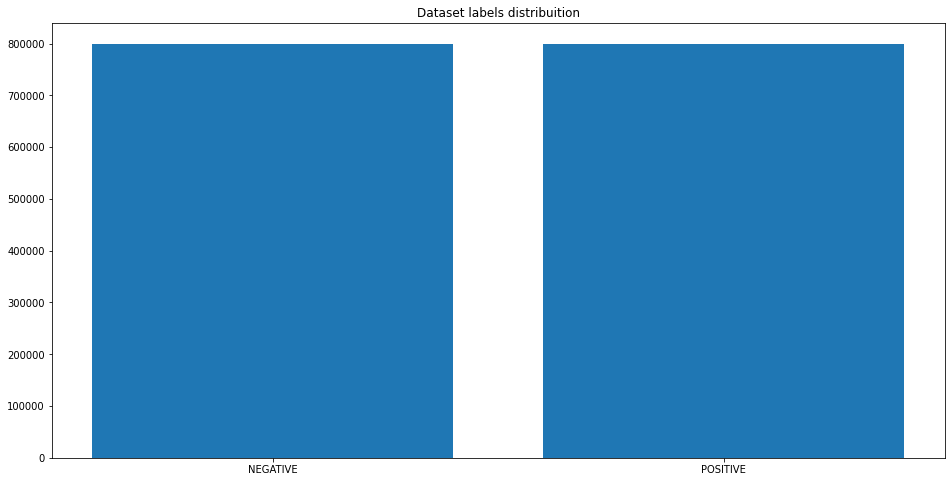

In [17]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [18]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [19]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [20]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 1min 9s


In [21]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec

In [22]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 4.55 s


In [23]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [24]:
w2v_model.build_vocab(documents)

2020-11-06 00:54:06,111 : INFO : collecting all words and their counts
2020-11-06 00:54:06,114 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-06 00:54:06,164 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-11-06 00:54:06,197 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-11-06 00:54:06,222 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-11-06 00:54:06,261 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-11-06 00:54:06,291 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-11-06 00:54:06,322 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-11-06 00:54:06,349 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-11-06 00:54:06,390 : INFO : PROGRESS: at s

2020-11-06 00:54:08,733 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-11-06 00:54:08,775 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-11-06 00:54:08,810 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-11-06 00:54:08,858 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-11-06 00:54:08,889 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-11-06 00:54:08,924 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-11-06 00:54:08,958 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-11-06 00:54:08,992 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-11-06 00:54:09,032 : INFO : PROGRESS: at sentence #800000, processed 577088

In [25]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [26]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-11-06 00:55:06,514 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-11-06 00:55:07,551 : INFO : EPOCH 1 - PROGRESS: at 6.30% examples, 510452 words/s, in_qsize 13, out_qsize 2
2020-11-06 00:55:08,558 : INFO : EPOCH 1 - PROGRESS: at 13.68% examples, 554296 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:55:09,635 : INFO : EPOCH 1 - PROGRESS: at 21.57% examples, 571766 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:55:10,654 : INFO : EPOCH 1 - PROGRESS: at 28.50% examples, 568959 words/s, in_qsize 14, out_qsize 1
2020-11-06 00:55:11,693 : INFO : EPOCH 1 - PROGRESS: at 34.35% examples, 546456 words/s, in_qsize 16, out_qsize 0
2020-11-06 00:55:12,728 : INFO : EPOCH 1 - PROGRESS: at 42.35% examples, 562714 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:55:13,746 : INFO : EPOCH 1 - PROGRESS: at 49.49% examples, 564362 words/s, in_qsize 16, out_qsize 1
2020-11-06 00:55:14,759 : INFO : EPOCH 1 - PROGRESS: 

2020-11-06 00:55:58,980 : INFO : EPOCH 4 - PROGRESS: at 11.30% examples, 456200 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:56:00,031 : INFO : EPOCH 4 - PROGRESS: at 17.13% examples, 456640 words/s, in_qsize 16, out_qsize 7
2020-11-06 00:56:01,037 : INFO : EPOCH 4 - PROGRESS: at 23.20% examples, 466637 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:56:02,087 : INFO : EPOCH 4 - PROGRESS: at 30.02% examples, 480286 words/s, in_qsize 16, out_qsize 0
2020-11-06 00:56:03,083 : INFO : EPOCH 4 - PROGRESS: at 35.75% examples, 478819 words/s, in_qsize 14, out_qsize 1
2020-11-06 00:56:04,099 : INFO : EPOCH 4 - PROGRESS: at 41.59% examples, 478182 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:56:05,111 : INFO : EPOCH 4 - PROGRESS: at 48.62% examples, 489837 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:56:06,127 : INFO : EPOCH 4 - PROGRESS: at 54.24% examples, 486362 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:56:07,147 : INFO : EPOCH 4 - PROGRESS: at 60.96% examples, 491529 words/s,

2020-11-06 00:56:52,091 : INFO : EPOCH 7 - PROGRESS: at 51.97% examples, 594296 words/s, in_qsize 14, out_qsize 1
2020-11-06 00:56:53,133 : INFO : EPOCH 7 - PROGRESS: at 60.20% examples, 601376 words/s, in_qsize 16, out_qsize 1
2020-11-06 00:56:54,135 : INFO : EPOCH 7 - PROGRESS: at 67.02% examples, 596870 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:56:55,129 : INFO : EPOCH 7 - PROGRESS: at 74.37% examples, 597663 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:56:56,210 : INFO : EPOCH 7 - PROGRESS: at 81.66% examples, 593582 words/s, in_qsize 16, out_qsize 0
2020-11-06 00:56:57,273 : INFO : EPOCH 7 - PROGRESS: at 89.89% examples, 597120 words/s, in_qsize 15, out_qsize 1
2020-11-06 00:56:58,312 : INFO : EPOCH 7 - PROGRESS: at 98.04% examples, 600896 words/s, in_qsize 13, out_qsize 2
2020-11-06 00:56:58,428 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-06 00:56:58,456 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-06 00:56:58,

2020-11-06 00:57:39,063 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-06 00:57:39,068 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-06 00:57:39,084 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-06 00:57:39,085 : INFO : EPOCH - 10 : training on 9227204 raw words (8222732 effective words) took 13.8s, 596146 effective words/s
2020-11-06 00:57:40,107 : INFO : EPOCH 11 - PROGRESS: at 7.28% examples, 595184 words/s, in_qsize 14, out_qsize 1
2020-11-06 00:57:41,124 : INFO : EPOCH 11 - PROGRESS: at 15.41% examples, 628144 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:57:42,122 : INFO : EPOCH 11 - PROGRESS: at 22.22% examples, 604378 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:57:43,145 : INFO : EPOCH 11 - PROGRESS: at 29.59% examples, 602856 words/s, in_qsize 16, out_qsize 0
2020-11-06 00:57:44,182 : INFO : EPOCH 11 - PROGRESS: at 37.70% examples, 609669 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:

2020-11-06 00:58:28,157 : INFO : EPOCH 14 - PROGRESS: at 61.82% examples, 623602 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:58:29,192 : INFO : EPOCH 14 - PROGRESS: at 69.07% examples, 618412 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:58:30,234 : INFO : EPOCH 14 - PROGRESS: at 76.00% examples, 610958 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:58:31,334 : INFO : EPOCH 14 - PROGRESS: at 83.62% examples, 606615 words/s, in_qsize 14, out_qsize 2
2020-11-06 00:58:32,350 : INFO : EPOCH 14 - PROGRESS: at 90.87% examples, 605021 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:58:33,350 : INFO : EPOCH 14 - PROGRESS: at 98.26% examples, 605033 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:58:33,491 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-06 00:58:33,508 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-06 00:58:33,508 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-06 00:58:33,540 : INFO : work

2020-11-06 00:59:15,011 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-06 00:59:15,014 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-06 00:59:15,018 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-06 00:59:15,019 : INFO : EPOCH - 17 : training on 9227204 raw words (8222101 effective words) took 13.7s, 598925 effective words/s
2020-11-06 00:59:16,045 : INFO : EPOCH 18 - PROGRESS: at 6.51% examples, 533894 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:59:17,052 : INFO : EPOCH 18 - PROGRESS: at 13.68% examples, 558356 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:59:18,055 : INFO : EPOCH 18 - PROGRESS: at 20.59% examples, 561312 words/s, in_qsize 15, out_qsize 0
2020-11-06 00:59:19,061 : INFO : EPOCH 18 - PROGRESS: at 28.29% examples, 577918 words/s, in_qsize 14, out_qsize 2
2020-11-06 00:59:20,077 : INFO : EPOCH 18 - PROGRESS: at 34.35% examples, 560884 words/s, in_qsize 16, out_qsize 0
2020-11-06 00:

2020-11-06 01:00:05,229 : INFO : EPOCH 21 - PROGRESS: at 59.66% examples, 534059 words/s, in_qsize 15, out_qsize 0
2020-11-06 01:00:06,278 : INFO : EPOCH 21 - PROGRESS: at 65.93% examples, 530239 words/s, in_qsize 16, out_qsize 0
2020-11-06 01:00:07,297 : INFO : EPOCH 21 - PROGRESS: at 72.97% examples, 533828 words/s, in_qsize 15, out_qsize 0
2020-11-06 01:00:08,298 : INFO : EPOCH 21 - PROGRESS: at 80.69% examples, 541596 words/s, in_qsize 14, out_qsize 1
2020-11-06 01:00:09,296 : INFO : EPOCH 21 - PROGRESS: at 88.48% examples, 548996 words/s, in_qsize 15, out_qsize 0
2020-11-06 01:00:10,349 : INFO : EPOCH 21 - PROGRESS: at 96.31% examples, 553771 words/s, in_qsize 15, out_qsize 0
2020-11-06 01:00:10,657 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-06 01:00:10,683 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-06 01:00:10,691 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-06 01:00:10,699 : INFO : work

2020-11-06 01:00:52,200 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-06 01:00:52,200 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-06 01:00:52,216 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-06 01:00:52,217 : INFO : EPOCH - 24 : training on 9227204 raw words (8224083 effective words) took 13.8s, 597351 effective words/s
2020-11-06 01:00:53,238 : INFO : EPOCH 25 - PROGRESS: at 7.49% examples, 608824 words/s, in_qsize 15, out_qsize 0
2020-11-06 01:00:54,300 : INFO : EPOCH 25 - PROGRESS: at 15.08% examples, 596551 words/s, in_qsize 16, out_qsize 0
2020-11-06 01:00:55,323 : INFO : EPOCH 25 - PROGRESS: at 21.79% examples, 580225 words/s, in_qsize 16, out_qsize 0
2020-11-06 01:00:56,338 : INFO : EPOCH 25 - PROGRESS: at 29.16% examples, 584506 words/s, in_qsize 14, out_qsize 1
2020-11-06 01:00:57,364 : INFO : EPOCH 25 - PROGRESS: at 36.83% examples, 590836 words/s, in_qsize 13, out_qsize 2
2020-11-06 01:

2020-11-06 01:01:41,645 : INFO : EPOCH 28 - PROGRESS: at 59.44% examples, 598836 words/s, in_qsize 14, out_qsize 1
2020-11-06 01:01:42,644 : INFO : EPOCH 28 - PROGRESS: at 66.58% examples, 596914 words/s, in_qsize 15, out_qsize 0
2020-11-06 01:01:43,683 : INFO : EPOCH 28 - PROGRESS: at 74.70% examples, 602387 words/s, in_qsize 13, out_qsize 2
2020-11-06 01:01:44,701 : INFO : EPOCH 28 - PROGRESS: at 81.23% examples, 594891 words/s, in_qsize 14, out_qsize 1
2020-11-06 01:01:45,746 : INFO : EPOCH 28 - PROGRESS: at 89.23% examples, 598130 words/s, in_qsize 15, out_qsize 0
2020-11-06 01:01:46,753 : INFO : EPOCH 28 - PROGRESS: at 96.75% examples, 598976 words/s, in_qsize 16, out_qsize 0
2020-11-06 01:01:47,045 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-06 01:01:47,045 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-06 01:01:47,084 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-06 01:01:47,092 : INFO : work

2020-11-06 01:02:27,849 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-06 01:02:27,854 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-06 01:02:27,858 : INFO : EPOCH - 31 : training on 9227204 raw words (8222846 effective words) took 13.1s, 625664 effective words/s
2020-11-06 01:02:28,881 : INFO : EPOCH 32 - PROGRESS: at 7.06% examples, 577741 words/s, in_qsize 15, out_qsize 0
2020-11-06 01:02:29,889 : INFO : EPOCH 32 - PROGRESS: at 15.08% examples, 614505 words/s, in_qsize 15, out_qsize 0
2020-11-06 01:02:30,922 : INFO : EPOCH 32 - PROGRESS: at 23.09% examples, 622297 words/s, in_qsize 15, out_qsize 0
2020-11-06 01:02:31,939 : INFO : EPOCH 32 - PROGRESS: at 30.99% examples, 625859 words/s, in_qsize 15, out_qsize 0
2020-11-06 01:02:32,975 : INFO : EPOCH 32 - PROGRESS: at 38.89% examples, 626597 words/s, in_qsize 16, out_qsize 0
2020-11-06 01:02:33,985 : INFO : EPOCH 32 - PROGRESS: at 45.70% examples, 615036 words/s, in_qsize 13, ou

Wall time: 7min 34s


(263127357, 295270528)

In [28]:
w2v_model.most_similar("love")

<ipython-input-28-9e1a4c826e7b>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar("love")
2020-11-06 01:02:41,729 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5758301019668579),
 ('loves', 0.5706297159194946),
 ('loved', 0.5444879531860352),
 ('amazing', 0.5121347904205322),
 ('adore', 0.5097287893295288),
 ('looove', 0.493882417678833),
 ('loveee', 0.4735329747200012),
 ('awesome', 0.47046369314193726),
 ('loooove', 0.4407847821712494),
 ('miss', 0.4292682409286499)]

### Tokenize Text

In [29]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 27.2 s


In [30]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 35.9 s


### Label Encoder

In [31]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [32]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [33]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [34]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

### Embedding layer

In [35]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [36]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### 4. Modeling

### Build Model

In [37]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile Model

In [38]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [39]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
 130/1125 [==>...........................] - ETA: 6:19:04 - loss: 0.5522 - accuracy: 0.7157

### Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

### Save Model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)